In [284]:
import papermill as pm
import scrapbook as sb
import pandas as pd
import os

import sqlite3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import matplotlib.dates as mdates

In [500]:
def get_data(token, from_date, to_date):
    '''
    This function is used for retrieving the data from SQL database
    
    Inputs:
    token (str) - name of token
    from_date (str) - start date of date range
    to_date (str) - end date of date range
    
    Outputs:
    df (DataFrame) - DataFrame with the data requested
    
    '''
    conn = sqlite3.connect('../../../Lectures/Lecture 4/data/data.db')
    cur = conn.cursor()
    cur.execute(f'''SELECT * FROM ohlc WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
    ''')
    
    data = cur.fetchall()
    
    df = pd.DataFrame(data,
                columns=['ts', 'open', 'high', 'low', 
                         'close', 'volume', 'volumeUSD', 
                         'token', 'chain'])
    conn.close()
    
    df['ts'] = pd.to_datetime(df['ts'])
    df.set_index('ts', inplace=True)
    return df

In [504]:
def get_stats(df, token, start_date, end_date):
    '''
    This function is used to calculate the statistical infromation for data
    
    Inputs:
    df (DataFrame) - inital data retrieved from SQL
    token (str) - name of token
    from_date (str) - start date of date range
    to_date (str) - end date of date range
    
    Outputs:
    df_token (DataFrame) - DataFrame with the required statistical information
    '''
    
    df = df[(df.index >= start_date)&(df.index <= end_date)]
    
    df_token = df[df['token'] == token]
    
    df_token['return'] = (np.log(df_token['close'] / df_token['close'].shift(1))).fillna(0)
    
    n_periods = (datetime.strptime(to_date, '%Y-%m-%d %H:%M:%S') - \
                 datetime.strptime(from_date, '%Y-%m-%d %H:%M:%S')).days
    
    df_token['volatility'] = (df_token['return'].rolling(n_periods).std() * np.sqrt(252)).fillna(0)
    
    df_token['roll_max'] = 0
    df_token['daily_dd'] = 0
    df_token['max_dd'] = 0
    
    for i in range(1, len(df_token)):
        window = i

        df_token.loc[df.index[i], 'roll_max'] = df_token['close'][:window].rolling(window, \
                                                                    min_periods=1).max().values[-1]
        df_token.loc[df.index[i], 'daily_dd'] = df_token['close'][i] / df_token['roll_max'][i] - 1

        df_token.loc[df.index[i], 'max_dd'] = df_token['daily_dd'][:window].rolling(window, \
                                                                    min_periods=1).min().values[-1]
    return df_token

In [481]:
def plot_charts(df, token, start_date, end_date):
    '''
    This function is used to create plot with statistical information
    
    Inputs:
    df (DataFrame) - inital data retrieved from SQL
    token (str) - name of token
    from_date (str) - start date of date range
    to_date (str) - end date of date range
    
    Outputs:
    fig (figure) - figure with required statistical information plotted
    '''
    
    df_tmp = get_stats(df, token, start_date, end_date)
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 7.5))
    
    axs[0, 0].plot(df_tmp.index, df_tmp['return'])
    axs[0, 0].set_title(token + ': Return')
    axs[0, 0].xaxis.set_major_locator(mdates.MonthLocator())

    axs[0, 1].plot(df_tmp.index, df_tmp['volatility'])
    axs[0, 1].set_title(token + ': Volatility')
    axs[0, 1].xaxis.set_major_locator(mdates.MonthLocator())
    
    axs[1, 0].plot(df_tmp.index, df_tmp['max_dd'])
    axs[1, 0].set_title(token + ': Maximum Drawdown')
    axs[1, 0].xaxis.set_major_locator(mdates.MonthLocator())

    axs[1, 1].plot(df_tmp.index, df_tmp['close'])
    axs[1, 1].set_title(token + ': Close Prices')
    axs[1, 1].xaxis.set_major_locator(mdates.MonthLocator())
    
    return fig

In [494]:
df = get_data(token, from_date, to_date)

In [499]:
get_stats(df, token, from_date, to_date)

,open,high,low,close,volume,volumeUSD,token,chain,return,volatility,roll_max,daily_dd,max_dd
ts,,,,,,,,,,,,,


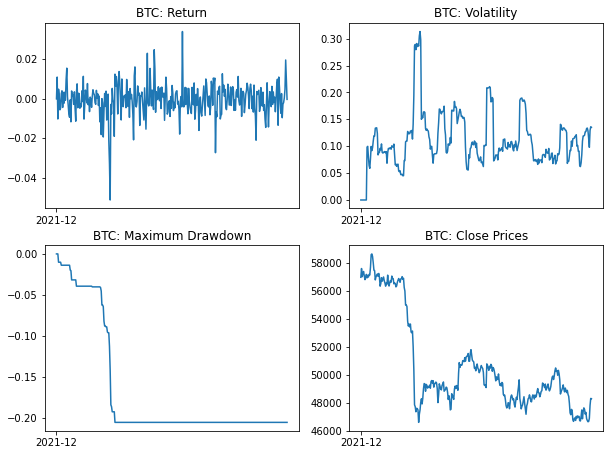

In [492]:
fig = plot_charts(df, token, from_date, to_date)

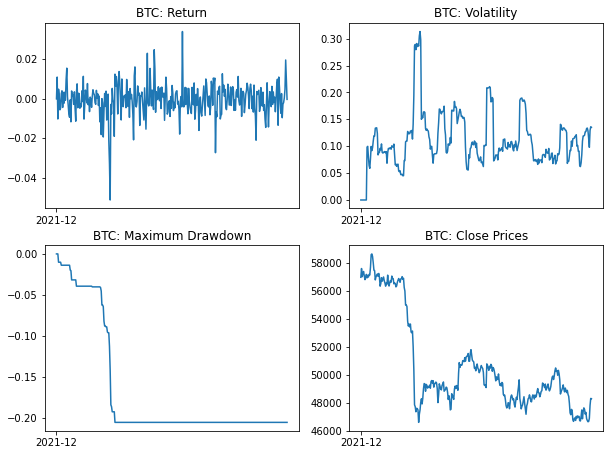

In [497]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('df', get_stats(df, token, from_date, to_date), encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)